In [1]:
#!pip install pystac_client planetary_computer geopandas rich rasterio matplotlib seaborn tabulate scikit-learn fiona

import pystac_client
import planetary_computer

import geopandas as gpd
import rasterio

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from rasterio.transform import from_bounds
from rasterio.mask import mask
import fiona

In [2]:
STAC_URL = 'https://planetarycomputer.microsoft.com/api/stac/v1'

image_collection = 'landsat-c2-l2'

area_of_interest = [98.919831,18.754418,99.049607,18.819261]

date_search = "2019-12-01/2019-12-31"

max_cloud_percentage = 30

In [1]:
# Define Data query

# Call STAC connection
def sign_in_and_get_collections(stac_url, collection_name, bbox, date_range, max_cloud_perc=30):
    catalog = pystac_client.Client.open(
                        stac_url,
                        modifier=planetary_computer.sign_inplace,
                        )
    return catalog.search(collections=[collection_name], 
                        bbox=bbox, 
                        datetime=date_range,
                        query={"eo:cloud_cover": {"lt": max_cloud_perc}}).item_collection()
 
 
def make_collection_table(items):
    return gpd.GeoDataFrame.from_features(items.to_dict(), crs="epsg:4326")

def get_preview(item):
    
    preview_asset_name = 'rendered_preview'
    
    with rasterio.open(item.assets[preview_asset_name].href) as src:
        
        return src.read()

def get_datacube(item, asset_name_list=['blue', 'green', 'red'], aoi_file=None):
    
    np_array_list = []
    
    if aoi_file:
        aoi_gdf = gpd.read_file(aoi_file)
        geometry = [aoi_gdf.unary_union]
    
    for asset_name in asset_name_list:
        
        with rasterio.open(item.assets[asset_name].href) as src:
            
            if aoi_file:
                out_image, out_transform = rasterio.mask.mask(src, geometry, crop=True)
                metadata = src.meta
                
                metadata.update({"driver": "GTiff",
                                "height": out_image.shape[1],
                                "width": out_image.shape[2],
                                "transform": out_transform})
                np_array_list.append(out_image)
                
            else:
                np_array_list.append(src.read())
            

    
    return np.vstack(np_array_list).transpose(1,2,0), metadata

def get_training_data_by_points(reference_data_url, stac_item, bands=['blue', 'green', 'red']):
    
    def sample_raster_values(raster, points): 
        with rasterio.open(raster) as src: 
            values = [] 
            for point in points:
                #print(point)
                coords = (point.x, point.y)
                value = list(src.sample([coords]))[0][0]
                values.append(value) 
        return values
    
    training_points = gpd.read_file(reference_data_url)

    for asset_name in bands:
        training_points[asset_name] =  sample_raster_values(stac_item.assets[asset_name].href, training_points.geometry)
        
    return training_points


def save_array_as_tif(image_data, metadata, output_tif_path):
    
    metadata.update({"driver": "GTiff",
                    "height": image_data.shape[0],
                    "width": image_data.shape[1]})
    
    # Save the clipped raster
    with rasterio.open(output_tif_path, "w", **metadata) as dest:
        dest.write(image_data[np.newaxis,:,:])
        
    print(f"Clipped raster saved to {output_tif_path}")
    


def read_stac_item_to_geotiff(item_url, output_path):
    """Reads a STAC item and saves it as a GeoTIFF.

    Args:
        item_url (str): The URL of the STAC item.
        output_path (str): The path to save the GeoTIFF.
    """

    # Load the STAC item
    item = Item.from_file(item_url)

    # Get the first asset (you can adjust this to select a specific asset)
    asset = item.assets['asset_key']  # Replace 'asset_key' with the actual asset key

    # Open the asset using rasterio
    with rasterio.open(asset.href) as src:
        # Read the image data
        image = src.read()

        # Copy metadata from the source dataset, updating the output format
        profile = src.profile
        profile.update(driver='GTiff')

        # Write the image data to the output GeoTIFF
        with rasterio.open(output_path, 'w', **profile) as dst:
            dst.write(image)


## 3. Land Cover Classification

In [4]:
print(f'======================= Before Change COLLECTION ==================== \n')

items_2014 = sign_in_and_get_collections(stac_url = STAC_URL, 
                        collection_name = image_collection, 
                        bbox = area_of_interest, 
                        date_range= "2014-01-01/2014-12-31", 
                        max_cloud_perc=max_cloud_percentage)

print(make_collection_table(items_2014).drop("geometry", axis='columns').to_markdown())

print(f'\n\n')

print(f'======================= AFTER Change COLLECTION ==================== \n')
items_2024 = sign_in_and_get_collections(stac_url = STAC_URL, 
                        collection_name = image_collection, 
                        bbox = area_of_interest, 
                        date_range= "2024-01-01/2024-12-31", 
                        max_cloud_perc=max_cloud_percentage)

print(make_collection_table(items_2024).drop("geometry", axis='columns').to_markdown())

======================= Before Change COLLECTION ==================== 

|    |   gsd | created                     | sci:doi          | datetime                    | platform   |   proj:epsg | proj:shape   | description                  | instruments     |   eo:cloud_cover | proj:transform                               |   view:off_nadir |   landsat:wrs_row | landsat:scene_id      |   landsat:wrs_path |   landsat:wrs_type |   view:sun_azimuth | landsat:correction   |   view:sun_elevation |   landsat:cloud_cover_land |   landsat:collection_number | landsat:collection_category   |
|---:|------:|:----------------------------|:-----------------|:----------------------------|:-----------|------------:|:-------------|:-----------------------------|:----------------|-----------------:|:---------------------------------------------|-----------------:|------------------:|:----------------------|-------------------:|-------------------:|-------------------:|:---------------------|---------------

In [5]:
item_select_2014 = 10
item_select_2024 = 7

/opt/anaconda3/envs/ttg-tes/lib/python3.10/site-packages/rasterio/__init__.py:355: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/var/folders/d1/pv_vgtx525d9v64kb01fvbz80000gn/T/ipykernel_20948/269246595.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


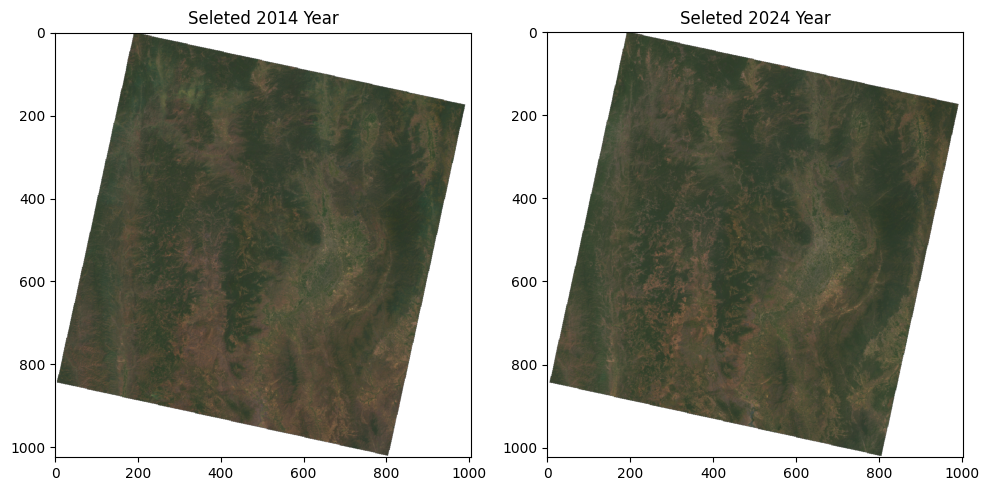

In [7]:
fig, axs = plt.subplots(1,2, figsize=(10, 5))

axs[0].imshow(get_preview(items_2014[item_select_2014]).transpose(1,2,0))
axs[0].set_title('Seleted 2014 Year')

axs[1].imshow(get_preview(items_2024[item_select_2024]).transpose(1,2,0))
axs[1].set_title('Seleted 2024 Year')

fig.tight_layout()
fig.show()

### Training Land cover classification model

In [44]:
select_spectral_bands = ['blue', 'green', 'red', 'nir08', 'swir16', 'swir22']
color_spectral_bands =['blue', 'lightgreen', 'red', 'darkred', 'gray', 'black']

y_name = {
    0: 'Unclassified',
    10: 'Vegetation',
    20: 'Shrubland',
    30: 'Grassland',
    40: 'Cropland',
    50: 'Built-up',
    60: 'Bareland',
    80: 'Water body'
}

y_color = [
    'black',
    'green',
    'orange',
    'yellow',
    'purple',
    'red',
    'lightgrey',
    'blue'
]

In [7]:
dataset_df = get_training_data_by_points(reference_data_url = 'https://raw.githubusercontent.com/thanthamky/tes-urban/refs/heads/main/training_points.geojson',
                            stac_item = items_2014[item_select_2024],
                            bands = select_spectral_bands)

In [8]:
dataset_df.loc[:, ['class_name', 'class1']+select_spectral_bands]

,class_name,class1,blue,green,red,nir08,swir16,swir22
0,Built-up,50,11037,12139,12425,15717,16298,14691
1,Vegetation,10,0,0,0,0,0,0
2,Vegetation,10,0,0,0,0,0,0
3,Vegetation,10,9551,9988,9830,16111,13907,11400
4,Vegetation,10,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
5346,Vegetation,10,0,0,0,0,0,0
5347,Vegetation,10,10814,11240,11303,17077,16414,13187
5348,Vegetation,10,10349,10870,10865,16445,15879,13715
5349,Vegetation,10,10624,10890,10881,17780,14956,12084


In [9]:
dataset_df.loc[dataset_df['nir08'] == 0, 'class1'] = 0
dataset_df.loc[dataset_df['nir08'] == 0, 'class_name'] = 'Unclassified'

dataset_df

,rand_point_id,class1,class_name,geometry,blue,green,red,nir08,swir16,swir22
0,0,50,Built-up,POINT (506804.64 2078222.051),11037,12139,12425,15717,16298,14691
1,1,0,Unclassified,POINT (513873.809 2090669.093),0,0,0,0,0,0
2,2,0,Unclassified,POINT (515665.318 2091346.788),0,0,0,0,0,0
3,3,10,Vegetation,POINT (528992.431 2103531.176),9551,9988,9830,16111,13907,11400
4,4,0,Unclassified,POINT (534679.876 2109160.968),0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
5346,5346,0,Unclassified,POINT (499621.97 2066309.964),0,0,0,0,0,0
5347,5347,10,Vegetation,POINT (501653.783 2070783.27),10814,11240,11303,17077,16414,13187
5348,5348,10,Vegetation,POINT (498789.872 2060700.84),10349,10870,10865,16445,15879,13715
5349,5349,10,Vegetation,POINT (504298.537 2065342.187),10624,10890,10881,17780,14956,12084


In [10]:
X = dataset_df.loc[:, select_spectral_bands]
y = dataset_df.loc[:, 'class1']

/var/folders/d1/pv_vgtx525d9v64kb01fvbz80000gn/T/ipykernel_51429/1216820655.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


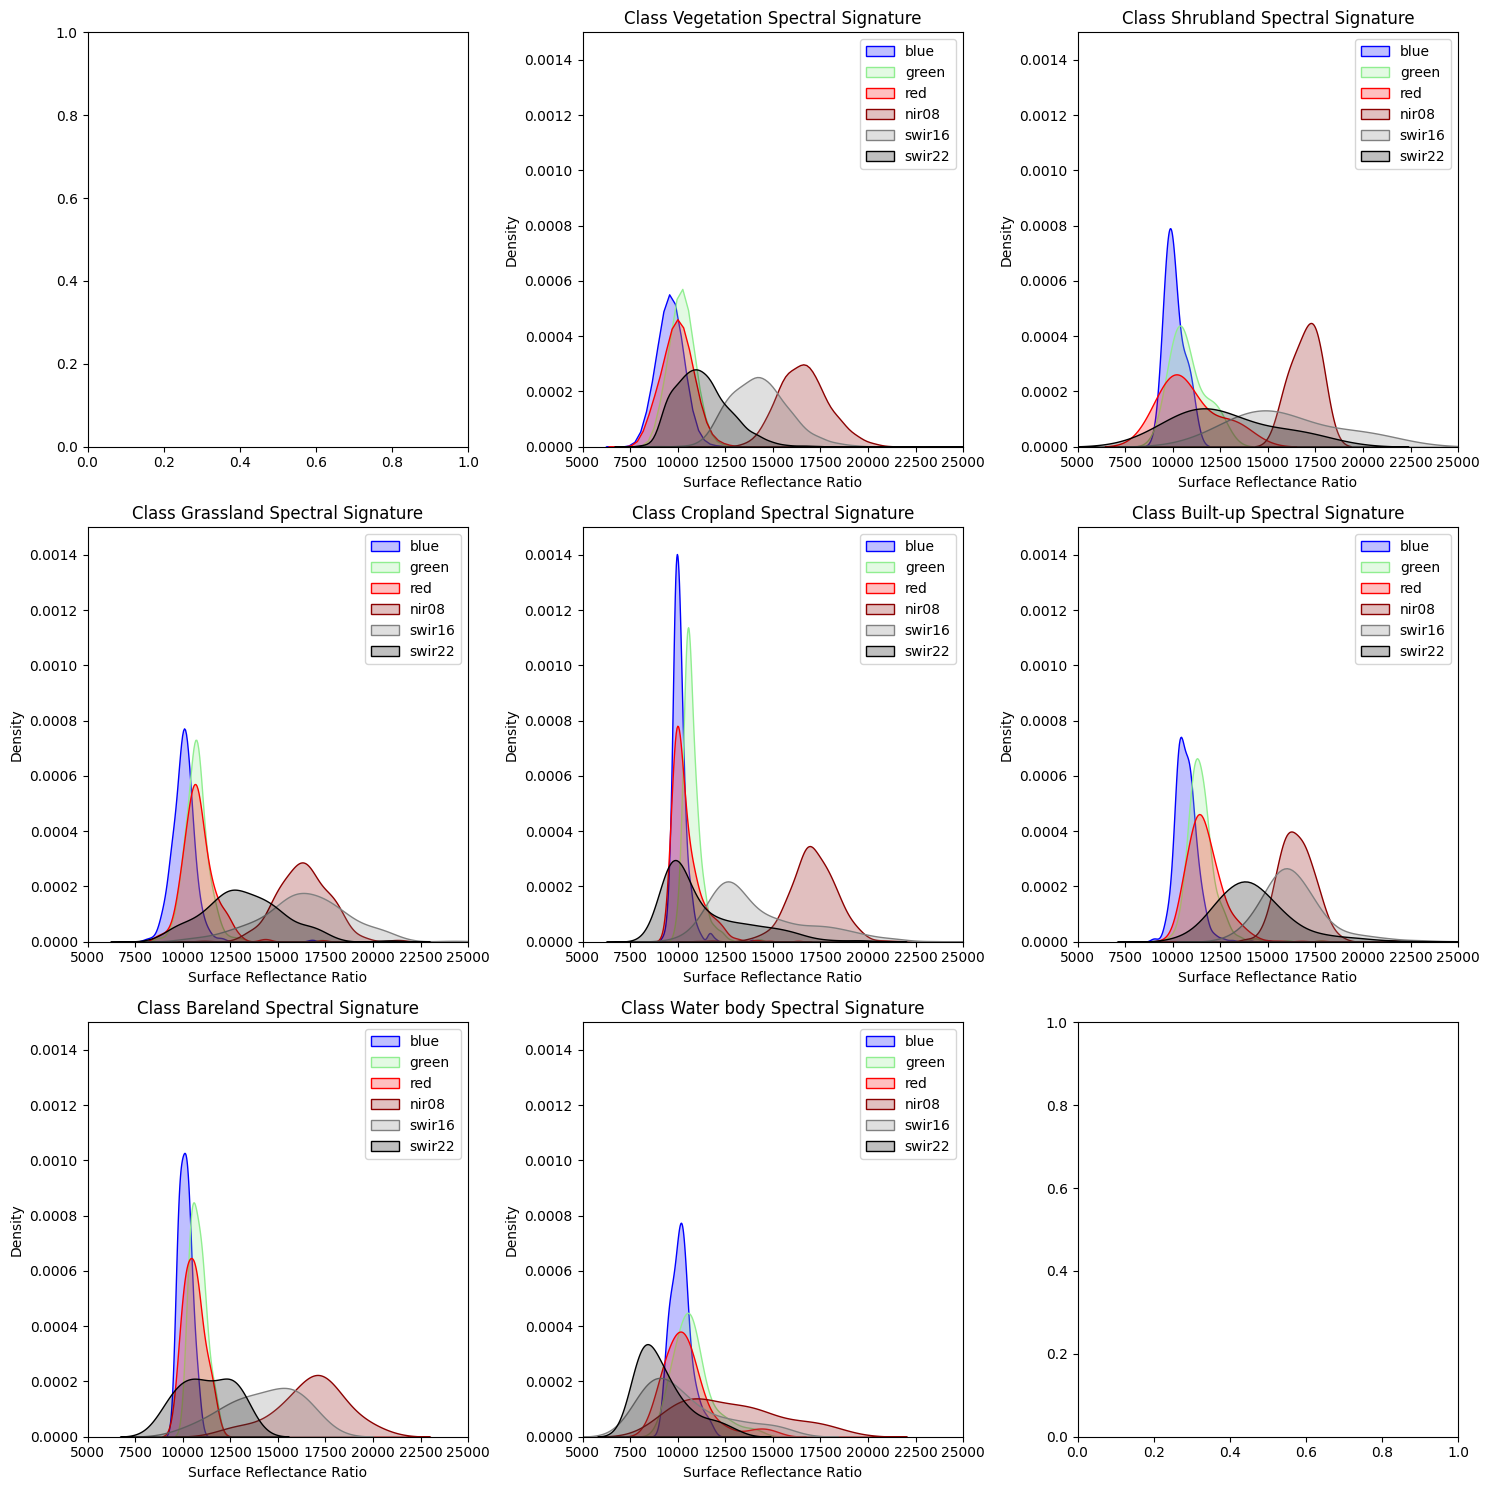

In [11]:
y_list = np.unique(y)

fig, axs = plt.subplots(3, 3, figsize=(15,15))
axs = axs.ravel()

for axs_idx, y_class in enumerate(y_list):
    
    if y_class == 0: continue
    
    # Example NumPy array
    data = X[y == y_class]
    
    for band_idx, (band, color) in enumerate(zip(select_spectral_bands, color_spectral_bands)):
        sns.kdeplot(data.iloc[:, band_idx], fill=True, color=color, label=band, ax=axs[axs_idx])
    
    
    axs[axs_idx].set_title(f'Class {y_name[y_class]} Spectral Signature')
    
    axs[axs_idx].set_ylabel('Density')
    axs[axs_idx].set_xlabel('Surface Reflectance Ratio')
    
    axs[axs_idx].set_xlim(5_000, 25_000)
    axs[axs_idx].set_ylim(0, 0.0015)

    axs[axs_idx].legend()
    
fig.tight_layout()
fig.show()

In [12]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [13]:
scaler = MinMaxScaler()

scaler.fit(X)

X_scale = scaler.transform(X)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, stratify=y)

In [15]:
print('Training shape: ', X_train.shape, y_train.shape)
print('Validation shape: ', X_test.shape, y_test.shape)

Training shape:  (4013, 6) (4013,)
Validation shape:  (1338, 6) (1338,)


In [16]:
#model = SVC()
model = RandomForestClassifier(n_jobs=-1)

model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1)

In [24]:
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred, target_names=y_name.values(), digits=3, zero_division=0))

              precision    recall  f1-score   support

Unclassified      1.000     1.000     1.000       269
  Vegetation      0.838     0.937     0.885       773
   Shrubland      0.000     0.000     0.000         1
   Grassland      0.400     0.161     0.230        62
    Cropland      0.652     0.462     0.541       130
    Built-up      0.613     0.533     0.570        92
    Bareland      0.000     0.000     0.000         3
  Water body      0.625     0.625     0.625         8

    accuracy                          0.835      1338
   macro avg      0.516     0.465     0.481      1338
weighted avg      0.813     0.835     0.818      1338



In [25]:
#X_2014 = get_datacube(items_2014[item_select_2014], select_spectral_bands)
X_2024, metadata = get_datacube(items_2024[item_select_2024], 
                      select_spectral_bands, 
                      aoi_file='https://raw.githubusercontent.com/thanthamky/tes-urban/refs/heads/main/aoi.geojson')

/var/folders/d1/pv_vgtx525d9v64kb01fvbz80000gn/T/ipykernel_51429/4012557907.py:32: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geometry = [aoi_gdf.unary_union]


In [26]:
inf_shape = X_2024.shape
X_2024_scale = scaler.transform(X_2024.reshape(-1, inf_shape[2]))

/opt/anaconda3/envs/ttg-tes/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [27]:
y_2024 = model.predict(X_2024_scale)

In [28]:
y_2024_reshape = y_2024.reshape(inf_shape[:2])

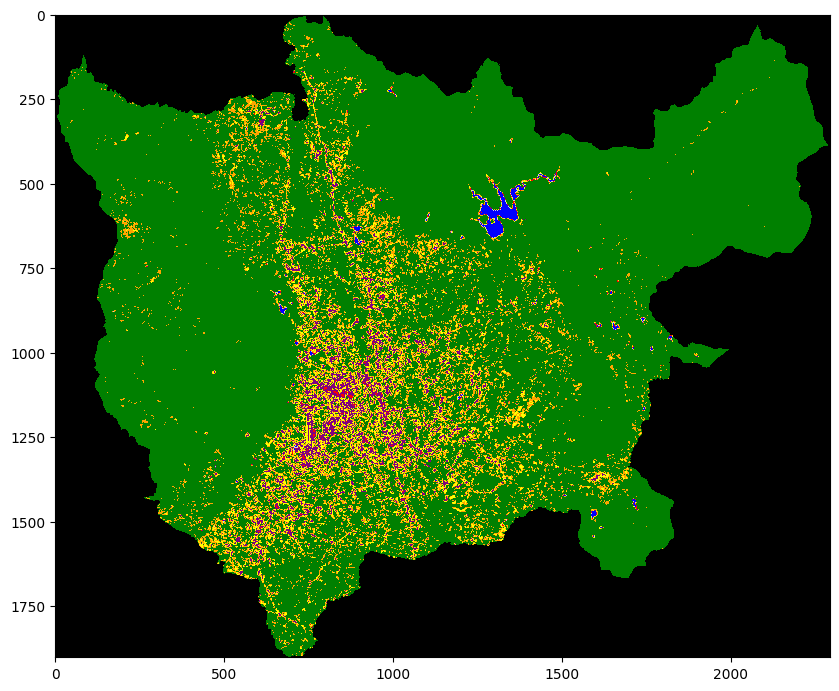

In [31]:
from matplotlib.colors import ListedColormap

color_map = ListedColormap(y_color)

plt.figure(figsize=(10,10))
plt.imshow(y_2024_reshape, cmap=color_map)
plt.show()

In [32]:
# Example usage
save_array_as_tif(y_2024_reshape, metadata, 'lulc_city_rf_2024.tif')

Clipped raster saved to lulc_city_rf_2024.tif


In [33]:
# Get the Inferencing input datacube
X_2014, metadata_2014 = get_datacube(items_2014[item_select_2014], 
                      select_spectral_bands, 
                      aoi_file='https://raw.githubusercontent.com/thanthamky/tes-urban/refs/heads/main/aoi.geojson')

# Transform the datacube (Scaling) and reshape to predictable form
inf_shape = X_2014.shape
X_2014_scale = scaler.transform(X_2014.reshape(-1, inf_shape[2]))

# Do prediction
y_2014 = model.predict(X_2014_scale)

# Reshape output like input shape (map dimension)
y_2014_reshape = y_2014.reshape(inf_shape[:2])

# Save output
save_array_as_tif(y_2014_reshape, metadata_2014, 'lulc_city_rf_2014.tif')

/var/folders/d1/pv_vgtx525d9v64kb01fvbz80000gn/T/ipykernel_51429/4012557907.py:32: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  geometry = [aoi_gdf.unary_union]
/opt/anaconda3/envs/ttg-tes/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Clipped raster saved to lulc_city_rf_2014.tif


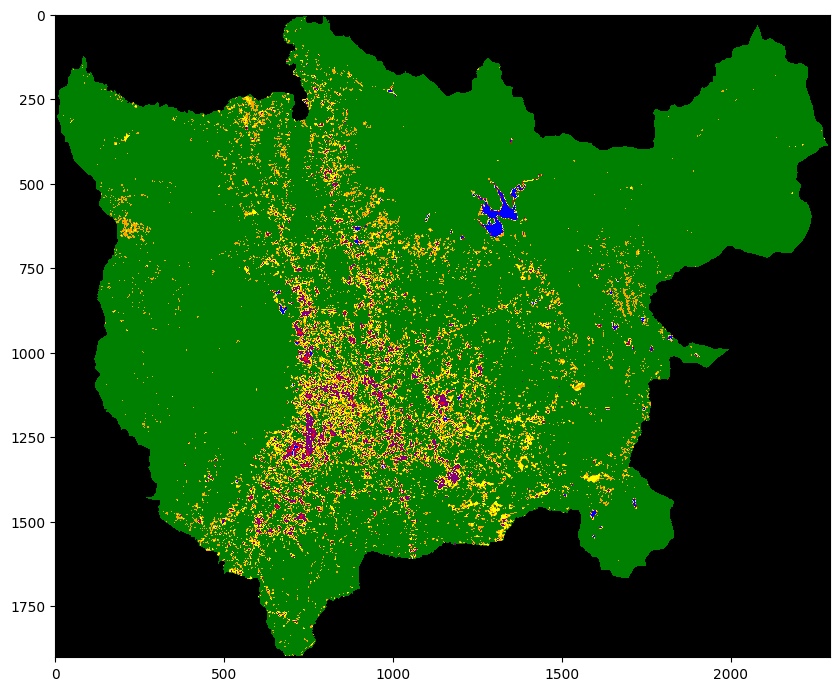

In [34]:
from matplotlib.colors import ListedColormap

color_map = ListedColormap(y_color)

plt.figure(figsize=(10,10))
plt.imshow(y_2014_reshape, cmap=color_map)
plt.show()

In [ ]:
# Get dataset 2014

# Read reference data

# Forming Training data

# Traing Model

# Inferencing map


In [ ]:
# Do same as 2024

## 4. Urban Land Classification and Area Analysis

In [ ]:
# Land cover change analysis (chart)

# Transition Matrix

# CA Markov explain

# Simulation Landcover change

In [22]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import LabelEncoder

np.set_printoptions(suppress=True,precision=3)

In [ ]:


def align_rasters(src_path1, src_path2):
    """Align two raster files to the same shape, resolution, and CRS."""
    
    with rasterio.open(src_path1) as src1, rasterio.open(src_path2) as src2:
        
        # Calculate the intersection of the extents
        left = max(src1.bounds.left, src2.bounds.left)
        bottom = max(src1.bounds.bottom, src2.bounds.bottom)
        right = min(src1.bounds.right, src2.bounds.right)
        top = min(src1.bounds.top, src2.bounds.top)
        intersect_bounds = (left, bottom, right, top)
        
        # Define a new transform and shape based on intersection
        transform, width, height = calculate_default_transform(
            src1.crs, src1.crs, src1.width, src1.height, *intersect_bounds
        )
        
        # Align the first raster
        aligned1 = np.empty((height, width), dtype=src1.meta['dtype'])
        reproject(
            source=rasterio.band(src1, 1),
            destination=aligned1,
            src_transform=src1.transform,
            src_crs=src1.crs,
            dst_transform=transform,
            dst_crs=src1.crs,
            resampling=Resampling.nearest,
        )
        
        # Save aligned raster 1
        profile = src1.profile
        
        # Align the second raster
        aligned2 = np.empty((height, width), dtype=src2.meta['dtype'])
        reproject(
            source=rasterio.band(src2, 1),
            destination=aligned2,
            src_transform=src2.transform,
            src_crs=src2.crs,
            dst_transform=transform,
            dst_crs=src1.crs,
            resampling=Resampling.nearest,
        )
    
    return aligned1, aligned2, profile

def calculate_transition(datacube_past, datacube_current):
    
    # Flatten arrays and calculate transition matrix
    transitions = confusion_matrix(datacube_past.flatten(), datacube_current.flatten(), normalize='true')

    return transitions


# Paths to your raster files
raster_past_path = 'lulc_city_rf_2014.tif'
raster_current_path = 'lulc_city_rf_2024.tif'

# Align rasters
datacube_past, datacube_current, raster_profile = align_rasters(raster_past_path, raster_current_path)

# Calculate transition matrix
transitions = calculate_transition(datacube_past, datacube_current)


In [ ]:
transitions

array([[1.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.923, 0.   , 0.028, 0.013, 0.035, 0.001],
       [0.   , 0.479, 0.   , 0.171, 0.085, 0.256, 0.009],
       [0.   , 0.591, 0.   , 0.28 , 0.063, 0.063, 0.002],
       [0.   , 0.544, 0.   , 0.159, 0.162, 0.128, 0.006],
       [0.   , 0.322, 0.   , 0.045, 0.04 , 0.591, 0.002],
       [0.   , 0.213, 0.   , 0.006, 0.014, 0.01 , 0.757]])

In [35]:
ts = transitions.transpose()
ts

array([[1.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.923, 0.479, 0.591, 0.544, 0.322, 0.213],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.028, 0.171, 0.28 , 0.159, 0.045, 0.006],
       [0.   , 0.013, 0.085, 0.063, 0.162, 0.04 , 0.014],
       [0.   , 0.035, 0.256, 0.063, 0.128, 0.591, 0.01 ],
       [0.   , 0.001, 0.009, 0.002, 0.006, 0.002, 0.757]])

In [37]:
class_sum = ts.sum(axis=1)
class_sum

array([1.   , 3.072, 0.001, 0.689, 0.378, 1.082, 0.778])

In [40]:
transitions = np.asarray([ts[i] / class_sum[i] for i in range(len(ts))])

In [41]:
pd.DataFrame(transitions)

,0,1,2,3,4,5,6
0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.0,0.300348,0.155782,0.192493,0.177141,0.104854,0.069381
2,0.0,0.060001,0.000000,0.446980,0.340877,0.152142,0.000000
3,0.0,0.040320,0.248108,0.406341,0.231463,0.065637,0.008131
4,0.0,0.034439,0.226255,0.167928,0.429770,0.104685,0.036924
5,0.0,0.032541,0.236874,0.057993,0.117963,0.545546,0.009083
6,0.0,0.001469,0.010990,0.002716,0.007726,0.003130,0.973969


In [42]:
pd.DataFrame(transitions)

,0,1,2,3,4,5,6
0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.0,0.300348,0.155782,0.192493,0.177141,0.104854,0.069381
2,0.0,0.060001,0.000000,0.446980,0.340877,0.152142,0.000000
3,0.0,0.040320,0.248108,0.406341,0.231463,0.065637,0.008131
4,0.0,0.034439,0.226255,0.167928,0.429770,0.104685,0.036924
5,0.0,0.032541,0.236874,0.057993,0.117963,0.545546,0.009083
6,0.0,0.001469,0.010990,0.002716,0.007726,0.003130,0.973969


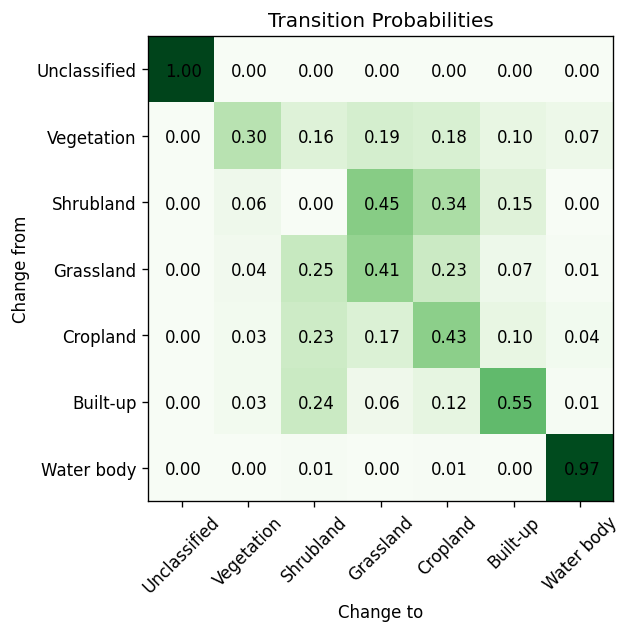

In [45]:
labels = [y_name[class_id] for class_id in np.unique(datacube_past).tolist()]

plt.figure(figsize=(5,9), dpi=120)

plt.imshow(transitions, cmap='Greens')

for i in range(transitions.shape[0]):
    
    for j in range(transitions.shape[1]):
        
        plt.text(j-0.25, i+0.1, f'{transitions[i, j]:.2f}')

plt.xticks(np.arange(len(labels)), labels, rotation=45)
plt.xlabel('Change to')

plt.yticks(np.arange(len(labels)), labels)
plt.ylabel('Change from')

plt.title('Transition Probabilities')
plt.show()

In [46]:
encoder = LabelEncoder()

map_shape = datacube_current.shape

In [47]:
datacube_current_enc = encoder.fit_transform(datacube_current.flatten()).reshape(map_shape)
datacube_past_enc = encoder.transform(datacube_past.flatten()).reshape(map_shape)

In [48]:
from tqdm import tqdm

In [49]:
!pip install tqdm

In [58]:
def update_map(current_datacube, transition_matrix, radius=1):
    
    NUM_CLASSES = len(np.unique(current_datacube))
    
    # Define a neighborhood kernel for cellular automata
    def get_neighbors(grid, x, y, radius=1):
        """
        Get the neighborhood values of a cell within a specified radius.
        Args:
            grid (numpy.ndarray): The grid.
            x (int): The row index of the cell.
            y (int): The column index of the cell.
            radius (int): The search radius (default is 1).
        Returns:
            numpy.ndarray: A flattened array of neighborhood values.
        """
        # Define the bounds of the neighborhood
        x_min = max(0, x - radius)
        x_max = min(grid.shape[0], x + radius + 1)
        y_min = max(0, y - radius)
        y_max = min(grid.shape[1], y + radius + 1)
        
        # Extract the neighborhood
        neighborhood = grid[x_min:x_max, y_min:y_max]
        
        return neighborhood.flatten()
    
    # Cellular Automata update function
    def update_cell(current_class, neighbors):
        """Update the cell class based on neighborhood influence and Markov transition."""
        class_counts = np.bincount(neighbors, minlength=NUM_CLASSES)
        influence = class_counts / class_counts.sum()

        # Combine neighborhood influence with Markov probabilities
        combined_probabilities = transition_matrix[current_class] * influence
        combined_probabilities /= combined_probabilities.sum()  # Normalize

        # Choose the new state based on probabilities
        return np.random.choice(np.arange(NUM_CLASSES), p=combined_probabilities)
    
    next_datacube = np.copy(current_datacube)
    
    for i in tqdm(range(current_datacube.shape[0])):
        
        for j in range(current_datacube.shape[1]):
            
            neighbors = get_neighbors(current_datacube, i, j, radius=2)
            next_datacube[i, j] = update_cell(current_datacube[i, j], neighbors)
            
    return next_datacube

In [ ]:
current_map = update_map(current_datacube=datacube_current_enc, transition_matrix=transitions, radius=2)

  4%|▍         | 74/1901 [00:04<01:43, 17.61it/s]


KeyboardInterrupt: 

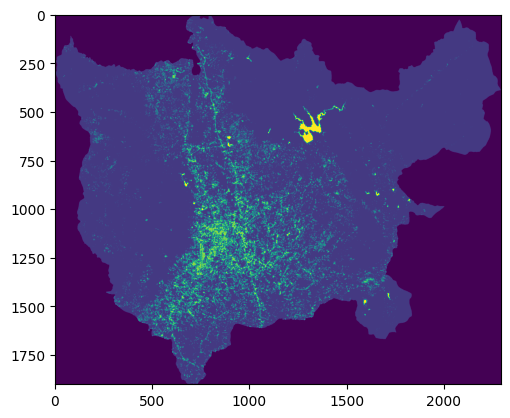

In [175]:
plt.imshow(current_map, cmap='viridis')

In [ ]:
simulation_step = 3

100%|██████████| 1901/1901 [01:49<00:00, 17.28it/s]


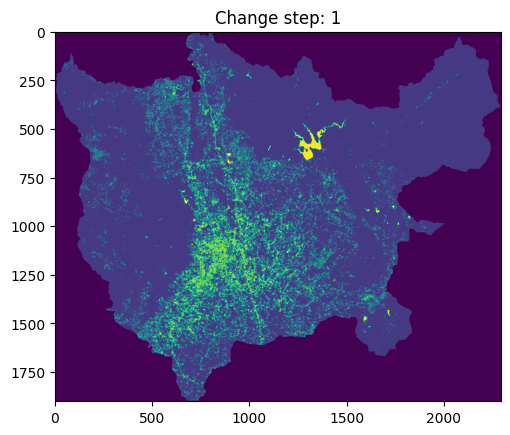

100%|██████████| 1901/1901 [01:48<00:00, 17.45it/s]


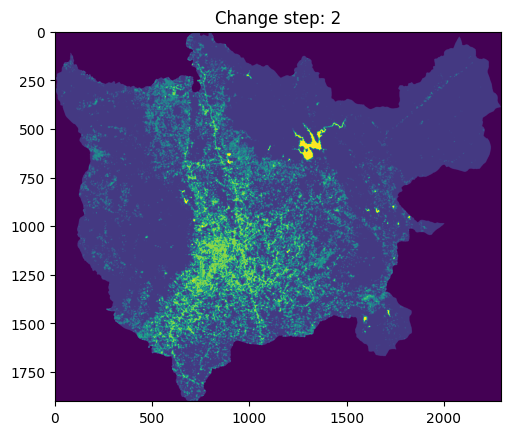

100%|██████████| 1901/1901 [01:48<00:00, 17.51it/s]


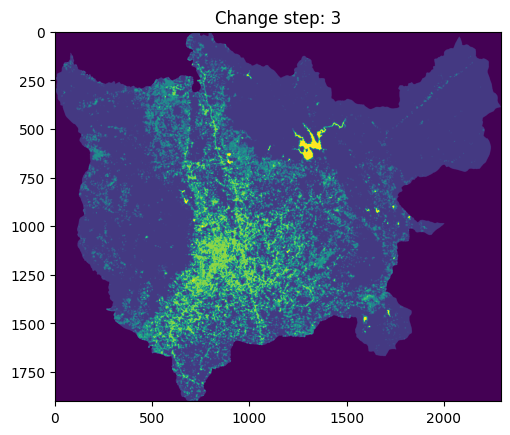

100%|██████████| 1901/1901 [01:49<00:00, 17.35it/s]


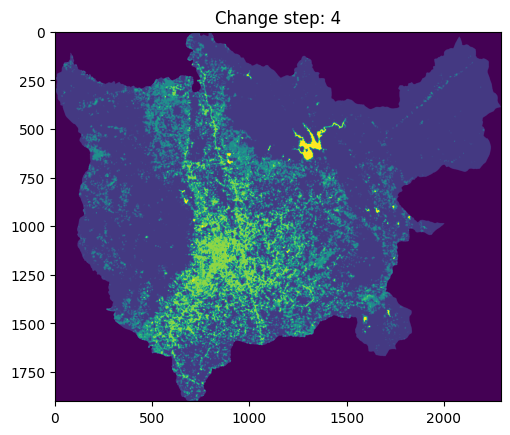

100%|██████████| 1901/1901 [01:48<00:00, 17.55it/s]


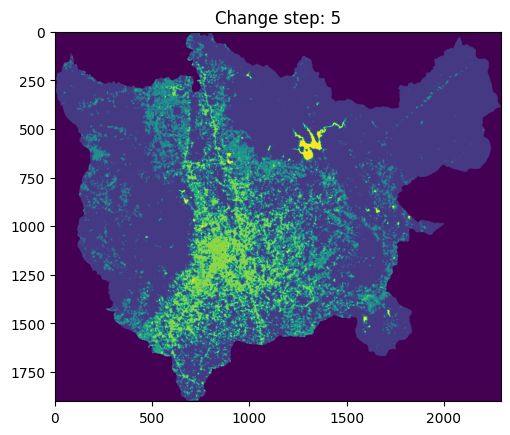

In [59]:
state_map = datacube_current_enc.copy()

for i in range(simulation_step):
    
    state_map = update_map(current_datacube=state_map, transition_matrix=transitions, radius=2)
    
    plt.title(f'Change step: {i+1}')
    plt.imshow(state_map, cmap='viridis')
    plt.show()

In [60]:
state_map_invenc = encoder.inverse_transform(state_map.flatten()).reshape(map_shape)

save_array_as_tif(state_map_invenc, raster_profile, 'lulc_city_camk_2024-3step_2.tif')

Clipped raster saved to lulc_city_camk_2024-3step_2.tif


In [182]:
np.unique(state_map_invenc)

array([ 0, 10, 30, 50, 80], dtype=uint16)

In [ ]:
# Change summary

# save future map

In [63]:
import pandas as pd
import plotly.graph_objects as go

label_list = ['cat', 'dog', 'domesticated', 'female', 'male', 'wild']
# cat: 0, dog: 1, domesticated: 2, female: 3, male: 4, wild: 5
source = [0, 0, 1, 3, 4, 4]
target = [3, 4, 4, 2, 2, 5]
count = [21, 6, 22, 21, 6, 22]

fig = go.Figure(data=[go.Sankey(
    node = {"label": label_list},
    link = {"source": source, "target": target, "value": count}
    )])
fig.show()

In [ ]:
transitions[1]

array([[0.   , 0.3  , 0.156, 0.192, 0.177, 0.105, 0.069],
       [0.   , 0.06 , 0.   , 0.447, 0.341, 0.152, 0.   ],
       [0.   , 0.04 , 0.248, 0.406, 0.231, 0.066, 0.008],
       [0.   , 0.034, 0.226, 0.168, 0.43 , 0.105, 0.037],
       [0.   , 0.033, 0.237, 0.058, 0.118, 0.546, 0.009],
       [0.   , 0.001, 0.011, 0.003, 0.008, 0.003, 0.974]])

In [67]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = labels
      
    ),
    link = dict(
      source = [0, 0, 1, 2, 3, 3], 
      target = [2, 3, 3, 4, 4, 5],
      value =  [8, 2, 4, 8, 4, 2],

  ))])

fig.update_layout(title_text="Basic Sankey Diagram", font_size=10,width=600, height=400)
fig.show()

In [69]:
!pip install pycirclize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 16.9 MB/s eta 0:00:00


In [77]:
labels

['Unclassified',
 'Vegetation',
 'Shrubland',
 'Grassland',
 'Cropland',
 'Built-up',
 'Water body']

In [83]:
from pycirclize import Circos
import pandas as pd


cm = confusion_matrix(datacube_past.flatten(), datacube_current.flatten())
                 
# Create matrix data (10 x 10)
row_names = list("ABCDEFGHIJ")
col_names = row_names
matrix_data = [
    [51, 115, 60, 17, 120, 126, 115, 179, 127, 114],
    [108, 138, 165, 170, 85, 221, 75, 107, 203, 79],
    [108, 54, 72, 123, 84, 117, 106, 114, 50, 27],
    [62, 134, 28, 185, 199, 179, 74, 94, 116, 108],
    [211, 114, 49, 55, 202, 97, 10, 52, 99, 111],
    [87, 6, 101, 117, 124, 171, 110, 14, 175, 164],
    [167, 99, 109, 143, 98, 42, 95, 163, 134, 78],
    [88, 83, 136, 71, 122, 20, 38, 264, 225, 115],
    [145, 82, 87, 123, 121, 55, 80, 32, 50, 12],
    [122, 109, 84, 94, 133, 75, 71, 115, 60, 210],
]

matrix_data = transitions

matrix_df = pd.DataFrame(matrix_data[1:, 1:], index=labels[1:], columns=labels[1:])

# Initialize from matrix (Can also directly load tsv matrix file)
circos = Circos.initialize_from_matrix(
    matrix_df,
    space=3,
    r_lim=(93, 100),
    cmap="tab10",
    ticks_interval=500,
    label_kws=dict(r=94, size=12, color="white"),
)

circos.savefig("chord_diagram01.png")


 <img src="chord_diagram01.png" />

In [82]:
transitions[1:, 1:]

array([[0.3  , 0.156, 0.192, 0.177, 0.105, 0.069],
       [0.06 , 0.   , 0.447, 0.341, 0.152, 0.   ],
       [0.04 , 0.248, 0.406, 0.231, 0.066, 0.008],
       [0.034, 0.226, 0.168, 0.43 , 0.105, 0.037],
       [0.033, 0.237, 0.058, 0.118, 0.546, 0.009],
       [0.001, 0.011, 0.003, 0.008, 0.003, 0.974]])

In [84]:
import pandas as pd

# Import the sankey function from the sankey module within pySankey
from pySankey.sankey import sankey

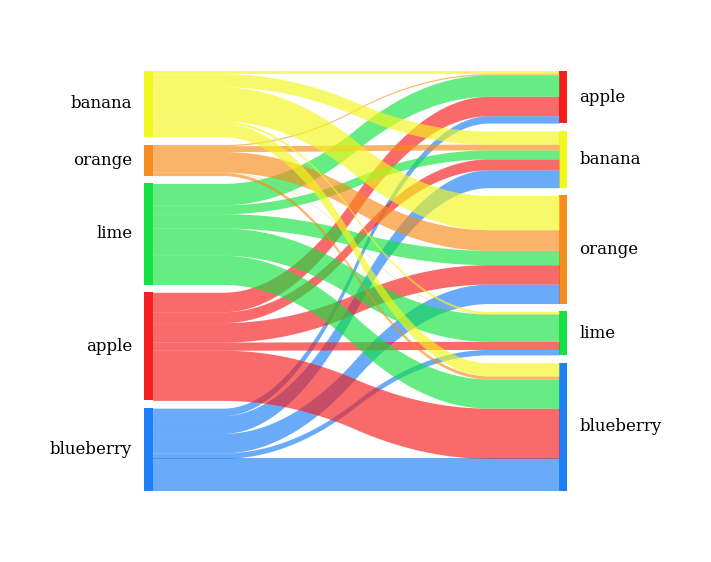

In [85]:
url = "https://raw.githubusercontent.com/anazalea/pySankey/master/pysankey/fruits.txt"
df = pd.read_csv(url, sep=" ", names=["true", "predicted"])

colors = {
    "apple": "#f71b1b",
    "blueberry": "#1b7ef7",
    "banana": "#f3f71b",
    "lime": "#12e23f",
    "orange": "#f78c1b"
}

sankey(df["true"], df["predicted"], aspect=20, colorDict=colors, fontsize=12)

In [86]:
df

,true,predicted
0,blueberry,blueberry
1,apple,blueberry
2,blueberry,blueberry
3,lime,lime
4,orange,orange
...,...,...
995,blueberry,banana
996,blueberry,blueberry
997,apple,apple
998,apple,banana
